# Seq2Seq Modeling



# 1. Setting up Colab

Here we set up colab.

In case u don't use colab, please specify the variable ```use_colab``` to false. In case u don't use it its unavoidable to make sure that noone changed something online while u change it offline. The results of this would be worse than a division by zero.  

In [1]:
use_colab: bool = True

In case u accidentally run the following code twice u will get following weird and confusing error:

```
OSError: [Errno 107] Transport endpoint is not connected
```

In this case just restart the runtime above. 


In [2]:
if use_colab:
  import os
  from google.colab import drive 
  drive.mount("/content/gdrive", force_remount=True)
  # Change directory for nicer imports
  %cd "/content/gdrive/My Drive/Data_Mining_Cup/05 Code/"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Data_Mining_Cup/05 Code


# 2. Nodes and Ideas

## Ideas for new Features
Please specify assignment in bold and brackets behind. If nobody is assigned put the "To Be Assigned (TBA)" Flague.
*

## Notes

did:
- finished implementation for attention
- did hyperparameter tuning 

results:
- can capture peaks, but its bad in predicting "flat" data (so all the zeros)


# 3. Setting up Notebook

Here we setup some parameters for the notebook to work in the expected ways.

If we want to **use the final test phase** for the later submission, we need to specify the following parameter **```make_final_submission``` to true.** Otherwise the selfmade test set will be used.

In [3]:
make_final_submission: bool = False 

In case we don't want to make a final submission, we now have to specify the test_set. In case you change it, please leave a comment on why and what the new one is. If the end is defined as None we use all the data from start_period (inclusive) till the end of dataset. 

In case make_final_submission is True we do not use those parameters.

In [4]:
# This will set the start of test period to 2 weeks before end of data

test_period_start: str="2018-06-02"
# Use till the end
test_period_end: str="2018-06-15"

In [5]:
# These datapoints are for the final submision
# final_submission_start: str="2018-06-30"
# final_submission_end: str="2018-07-14"

#### Imports

Here you can add imports u need. Please use alphabetical order to not import new stuff twice.

In [6]:
from datetime import date, datetime, timedelta
from itertools import product
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.layers import TimeDistributed
from keras.layers.merge import concatenate
import numpy as np
from numpy import save
from numpy import load
from math import sqrt 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from tensorflow import keras
import tensorflow as tf
from typing import List, Union

%matplotlib inline

Using TensorFlow backend.


In case of a "Model not found" Error concerning the Hyperopt package. Please uncomment and run the following line

In [7]:
# !pip install hyperopt

# Loading data

Here we now load the dataframes by the preceeding notebooks.
Please do not import single datasets and merge them here cause it will end in fatal inconsistencies.


# Preparation
#### Here the data is finally fetched

In [8]:
# OPEN PANDAS DATAFRAMES FROM PREPROCESSING 2
try:
  if make_final_submission: # mixed version!! nb2 and final (initial names were wrong)
    dynamic_features = pd.read_pickle('./data/dynamic_features_final.pk')
    static_features = pd.read_pickle('./data/static_features_nb2.pk')
  else:
    dynamic_features = pd.read_pickle('./data/dynamic_features_nb2.pk')
    static_features = pd.read_pickle('./data/static_features_nb2.pk')
except FileNotFoundError as e:
  print(f"One File could not be found. Please rerun the first Notebook, {e}")

In [9]:
# Number of all items
num_all_items = static_features.shape[0]
print(f"Number of all items: {num_all_items}")

# define how many items will be used
#items = num_all_items
items = 10463

Number of all items: 10463


####Here the static features are preprocessed

In [10]:
# static features have the correct shape, but need to scaled, as not all features are one-hot encoded
cat_features_one_day = static_features

cat_features_one_day = cat_features_one_day[:items]

# Transform dataframe into numpy array
cat_features_one_day = cat_features_one_day.values

# Scale the static featues
# Scale along the items (vertical)
scalerCat = RobustScaler()
scalerCat.fit(cat_features_one_day)
cat_features_one_day = scalerCat.transform(cat_features_one_day)
cat_features_one_day = pd.DataFrame(data=cat_features_one_day)

# Static features are constant over the prediction period
num_prediction_days = 14

# cat_features shape: (items, days, features)
cat_features = []
for i in range(num_prediction_days):
  cat_features.append(cat_features_one_day)

cat_features = np.stack(cat_features, axis=1)

print(cat_features.shape)

(10463, 14, 607)


In [11]:
# define amount of static features
num_cat_features = len(static_features.columns)
print(f"Using {num_cat_features} static features")

Using 607 static features


####Here the dynamic features are preprocessed

In [12]:
# Delete "lag" features
col_to_drop = [c for c in dynamic_features.columns if "order_t-" in c]
print(f"Dropping lag features {col_to_drop}")
dynamic_features = dynamic_features.drop(columns=col_to_drop)

Dropping lag features ['order_t-1', 'order_t-2', 'order_t-3', 'order_t-4', 'order_t-5', 'order_t-6', 'order_t-7', 'order_t-8', 'order_t-9', 'order_t-10', 'order_t-11', 'order_t-12', 'order_t-13', 'order_t-14']


In [13]:
# Delete features that are all None (at the time of writing, one feature only had None values)
dynamic_features = dynamic_features.dropna(axis=1, how='all')

In [14]:
# define amount of dynamic features

num_features = len(dynamic_features.columns)
print(f"Using {num_features} dynamic features")

Using 19 dynamic features


In [15]:
dynamic_features_names = dynamic_features.columns.to_list()
#dynamic_features_names = dynamic_features_names[:-14]

print(dynamic_features_names)

['order', 'salesPrice', 'promoted', 'avg_salesPrice_nonunique', 'day_of_year', 'day_of_month', 'month', 'week_nr', 'day_of_week', 'de_holidays', 'salesPrice_bucket__1', 'salesPrice_bucket__2', 'salesPrice_bucket__3', 'salesPrice_bucket__4', 'salesPrice_bucket__5', 'salesPrice_bucket__6', 'salesPrice_bucket__7', 'salesPrice_bucket__8', 'salesPrice_bucket__9']


##### Scaling dynamic features

In [16]:
# Scale per feature over all items, not for each item separately
#global_dynamic_scaler = MinMaxScaler(feature_range=(0, 1000))
global_dynamic_scaler = RobustScaler()
scaled_dynamic_features = global_dynamic_scaler.fit_transform(dynamic_features)

In [17]:
dynamic_features = pd.DataFrame(index=dynamic_features.index, data=scaled_dynamic_features, columns=dynamic_features.columns)

In [18]:
dynamic_features = dynamic_features.fillna(0)

In [19]:
# we thought it returns
def change_table (df):
  liste=[]
  for item in range(1, num_all_items+1):
    df_next = df.loc[item]
    df_next = df_next.add_suffix('_'+ str(item))
    liste.append(df_next)

  df = pd.concat(liste, axis=1)
  return df

In [20]:
dynamic_features = change_table(dynamic_features[dynamic_features_names])

In [21]:
np.amax(dynamic_features['order_1'])
dynamic_features['order_1'][-56:-42]

date
2018-05-05    0.0
2018-05-06    1.0
2018-05-07    0.0
2018-05-08    0.0
2018-05-09    0.0
2018-05-10    0.0
2018-05-11    0.0
2018-05-12    0.0
2018-05-13    0.0
2018-05-14    1.0
2018-05-15    0.0
2018-05-16    1.0
2018-05-17    0.0
2018-05-18    0.0
Name: order_1, dtype: float64

####Here we can make the dynamic features a bit smaller (static data shortened already at beginning):

In [22]:
# shorten dynamic data if necessary

dynamic_features = dynamic_features.iloc[:,:(num_features*items)]

# Do not touch last 2 weeks of training set (use as test set at the end)
dynamic_features = dynamic_features[:test_period_end]

dynamic_features = dynamic_features.T # transpose it

dynamic_features.shape


(198797, 166)

#### Preprocessing functions (need later on for training and validation)

In [23]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in dynamic_features.columns[:]]),
                          data=[i for i in range(len(dynamic_features.columns[:]))])

# transform data frame into numpy array
series_array = dynamic_features[dynamic_features.columns[:]].values


def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array,num_features,scaler=None):
    # Scaling is done above, "globally. Argument scaler is kept in case 
    # we later decide to change it back to scalig features for every item 
    # separately.


    # transpose   
    # series_array = series_array.T <-- not needed now

    if scaler is None:
      scaler = MinMaxScaler()

    #   scaler.fit(series_array) <-- not needed now
    # series_array = scaler.transform(series_array).T <-- not needed now

    arrays = []
    for i in range(num_features):
      arrays.append(series_array[i:series_array.shape[0]:num_features,:])

    series_array = np.stack(arrays, axis=2)
    
    return series_array, scaler

def transform_series_decode(series_array, scaler,num_features):
    series_array, _ = transform_series_encode(series_array,num_features,scaler)
    return series_array

In [24]:
data_start_date = dynamic_features.columns[0]
data_end_date = dynamic_features.columns[-1]
print('Data ranges from %s to %s (testing included)' % (data_start_date, data_end_date))

Data ranges from 2018-01-01 00:00:00 to 2018-06-15 00:00:00 (testing included)


#### Define train and val set

In [25]:
pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = data_start_date

last_day = data_end_date - pred_length 
# last_day = data_end_date <--- old version

# 2018-05-19 to 2018-06-01
val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

# 2018-05-05 to 2018-05-18
train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

# 2018-06-02 to 2018-06-15
test_pred_start = pd.Timestamp(test_period_start)
test_pred_end = pd.Timestamp(test_period_end)

In [26]:
# Now 124 days
enc_length = train_pred_start - first_day

# 2018-01-01 to 2018-05-04 (encoder)
train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

# 2018-01-15 to 2018-05-18 (encoder)
val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

# 2018-01-29 to 2018-06-01 (encoder)
test_enc_start = test_pred_start - enc_length
test_enc_end = test_pred_start - timedelta(1)

In [27]:
print('Train encoding:  ', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:    ', val_enc_start, '-', val_enc_end)
print('Val prediction:  ', val_pred_start, '-', val_pred_end, '\n')
print('Test encoding:    ', test_enc_start, '-', test_enc_end)
print('Test prediction:  ', test_pred_start, '-', test_pred_end, '\n')

print('Encoding interval: ', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding:   2018-01-01 00:00:00 - 2018-05-04 00:00:00
Train prediction: 2018-05-05 00:00:00 - 2018-05-18 00:00:00 

Val encoding:     2018-01-15 00:00:00 - 2018-05-18 00:00:00
Val prediction:   2018-05-19 00:00:00 - 2018-06-01 00:00:00 

Test encoding:     2018-01-29 00:00:00 - 2018-06-01 00:00:00
Test prediction:   2018-06-02 00:00:00 - 2018-06-15 00:00:00 

Encoding interval:  124
Prediction interval: 14


# The Custom Evaluation and Objective Function

Here is space to create several custom evaluation and objective functions to later use in seq2seq model.

### Karins First approach


In [28]:
# CHANGED: commented this. Let's wait for the "official" metric :P

# from sklearn.metrics import make_scorer

# def custom_loss(y_true, y_pred, item_price):
#     if y_true == y_pred:
#         revenue = item_price * y_pred 
#     elif y_true > y_pred:
#         revenue = item_price * y_pred 
#     else:
#         revenue = item_price * (y_true + 0.6 * (y_true - y_pred)) # here (y_true - y_pred) is negative 
#     return revenue 

# my_custom_score = make_scorer(custom_loss, greater_is_better=True)

# Seq2Seq Model: Training

#### Defining the model for training

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 124, 19)      0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 14, 19)       0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 124, 100), ( 48000       input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 14, 100), (N 48000       input_8[0][0]                    
                                                                 lstm_3[0][1]               

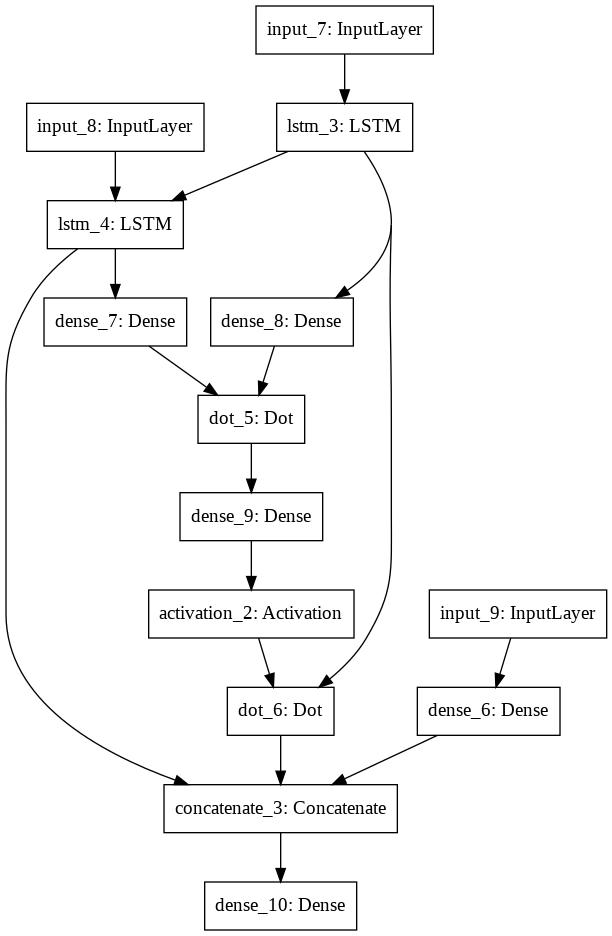

In [49]:
# Buildung the Model - Training Architecture
from tensorflow.keras.layers import Attention
from keras.layers import Activation, dot, concatenate

latent_dim = 100 # LSTM hidden units
dropout = 0 

# removed categorical features first of all

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(124, num_features)) 
encoder = LSTM(units=latent_dim, dropout=dropout, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
# state_h and state_c keep last state, although return_sequences=True
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
# teacher forcing: 
# - training: feed true values from t-1 to t0 for every time step in input in the decoder
# - prediction time: instead of true values, use predicted values for each previous time step
decoder_inputs = Input(shape=(14, num_features)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# categorical inputs
categorical_inputs = Input(shape=(14, num_cat_features)) 
dense_cat = Dense(num_cat_features)(categorical_inputs)

# attention
# only use last encoder state instead of whole sequence, as outputted now
#context_vector = Attention()([encoder_outputs, decoder_outputs])

dense_1_att = Dense(5000, activation='tanh')
t1 = dense_1_att(decoder_outputs)
dense_2_att = Dense(5000, activation='tanh')
t2 = dense_2_att(encoder_outputs)
attention = dot([t1, t2], axes=[2, 2])
dense_3_att = Dense(124, activation='tanh')
attention = dense_3_att(attention)
acti_1_att = Activation('softmax')
attention = acti_1_att(attention)
context = dot([attention, encoder_outputs], axes = [2,1])

# decoder_outputs shape (None, None, 100), dense_cat shape (None, None, 9)
final_dense_input = concatenate([dense_cat,decoder_outputs,context])

#final_dense_input = concatenate([dense_cat, final_dense_input])

# 1 continuous output at each timestep (just predict for 1 day in future, then via for loop the next one...)
# activation function ReLU, do not get negative values?
# Shrink output for each timestep in the decoder (latent_dim + cat_features) down to 50 values, then to 1 output (daily sailes)
# for e. g. 5000 values to 50 -> 5000 * 50 + 50 weights
# decoder_dense_1 = Dense(50,activation='relu')
# final_dense_output_1 = decoder_dense_1(final_dense_input)

decoder_dense_2 = Dense(1)
final_dense_output = decoder_dense_2(final_dense_input)

# Define the model
model = Model([categorical_inputs,encoder_inputs, decoder_inputs], final_dense_output)

model.summary()

# model outputs vector (with latent_dim, here = 100) for every time step in the decoder, as return_sequence = True)
# But only need one number per timestep -> Dense layers
# no timedistributed dense-layers, as it makes no difference with new keras version: https://stackoverflow.com/questions/49151607/why-does-the-keras-sequence-to-sequence-tutorial-not-mention-the-timedistributed
plot_model(model) # , to_file='seq2seq_daily_model.png')

#### Preprocessing encoder, decoder and target data for training 

In [47]:
# Set to true if you want to override the saved data
override_saved = True

In [48]:
# shape: item, days, features

# trys to open existing files
try:
  if override_saved:
    print("Saving new data")
    raise IOError  # A hack but this needed the smallest code change :D
  encoder_input_data = load('./data/seq2seq_intermediate/encoder_input_data_train.npy')
  decoder_target_data = load('./data/seq2seq_intermediate/decoder_target_data_train.npy')
  cat_features = load('./data/seq2seq_intermediate/cat_features.npy')
  print("loaded successfully")
except IOError as e:
  if not override_saved:
    print(f"Data could not be found. Encoder and decoder data will be created again, {e}")
  # sample of series from train_enc_start to train_enc_end  
  encoder_input_data = get_time_block_series(series_array, date_to_index, train_enc_start, train_enc_end)
  encoder_input_data, scaler = transform_series_encode(encoder_input_data,num_features)

  # sample of series from train_pred_start to train_pred_end 
  decoder_target_data = get_time_block_series(series_array, date_to_index, train_pred_start, train_pred_end)
  decoder_target_data = transform_series_decode(decoder_target_data, scaler ,num_features)

  # save preprocessed data
  save('./data/seq2seq_intermediate/encoder_input_data_train.npy', encoder_input_data)
  save('./data/seq2seq_intermediate/decoder_target_data_train.npy', decoder_target_data)
  save('./data/seq2seq_intermediate/cat_features.npy', cat_features)
  print("saved successfully")

# lagged target series for teacher forcing (hereby it learns given the daily sailes from day t to predict it from t+1 (output of model))
decoder_input_data = np.zeros(decoder_target_data.shape)
# all elements are shifted one timestep forward
decoder_input_data[:,1:,:] = decoder_target_data[:,:-1,:]
# first element of decoder is filled with last element of encoder
decoder_input_data[:,0,:] = encoder_input_data[:,-1,:]


# target data (daily sales) is first dimension (0 not 1)
target_dim = 0
decoder_target_data = decoder_target_data[:,:,target_dim].reshape((items,14,1))

Saving new data
saved successfully


#### Train the seq2seq model


In [ ]:
# for one item: changed batchsize (20) and validation_split (0.2), , insert callbacks=[es] in model.fit

batch_size = 100
epochs = 300

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=50,
#     decay_rate=0.5)

#, decay=1e-4/epochs

opt = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=opt, loss='mse')

#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
                 
history = model.fit([cat_features,encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

# best with attention, standardscaler and 10 items: 9.8e-4
# after fillna(0), robustscaler and 100 items: best 0.41
# but high validation loss -> overfitting
# possible problem: peaky data is fine, but not for flat data

Train on 8370 samples, validate on 2093 samples
Epoch 1/300
8370/8370 [==============================] - 41s 5ms/step - loss: 798.6508 - val_loss: 198.7210
Epoch 2/300
8370/8370 [==============================] - 41s 5ms/step - loss: 793.6864 - val_loss: 198.3469
Epoch 3/300
8370/8370 [==============================] - 40s 5ms/step - loss: 791.8081 - val_loss: 199.4373
Epoch 4/300
8370/8370 [==============================] - 40s 5ms/step - loss: 791.0014 - val_loss: 199.8174
Epoch 5/300
8370/8370 [==============================] - 40s 5ms/step - loss: 791.9535 - val_loss: 200.4754
Epoch 6/300
8370/8370 [==============================] - 42s 5ms/step - loss: 789.5883 - val_loss: 232.6675
Epoch 7/300
8370/8370 [==============================] - 41s 5ms/step - loss: 789.5791 - val_loss: 201.4014
Epoch 8/300
8370/8370 [==============================] - 41s 5ms/step - loss: 788.1307 - val_loss: 201.9973
Epoch 9/300
8370/8370 [==============================] - 41s 5ms/step - loss: 787.0258 -

####Print loss history for train and val set

In [ ]:

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
#plt.legend(['Train','Valid'])

#### See how one item performs on prediction period

In [ ]:
prediction_data = model.predict([cat_features,encoder_input_data, decoder_input_data])
item = 97

print(prediction_data.shape)
print(decoder_target_data.shape)

prep_prediction_data = prediction_data[item,:,:].reshape(-1)
prep_decoder_target_data = decoder_target_data[item,:,0].reshape(-1)

plt.plot(prep_prediction_data)
plt.plot(prep_decoder_target_data)
plt.legend(['Prediction','Ground Truth'])

#Seq2Seq Model: Validation

####Defining the model for the inference 

In [ ]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, [encoder_outputs]+encoder_states)


# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# categorical inputs
# num_cat_features = 3
# categorical_inputs = Input(shape=(None, num_cat_features)) 
# dense_cat = Dense(num_cat_features)(categorical_inputs)
encoder_outputs_inference = Input(shape=(124, latent_dim)) 
t1 = dense_1_att(decoder_outputs)
t2 = dense_2_att(encoder_outputs_inference)
attention = dot([t1, t2], axes=[2, 2])
attention = dense_3_att(attention)
attention = acti_1_att(attention)
context = dot([attention, encoder_outputs_inference], axes = [2,1])

final_dense_input = concatenate([dense_cat,context, decoder_outputs])


#final_dense_output_1 = decoder_dense_1(final_dense_input)
final_dense_output = decoder_dense_2(final_dense_input)

decoder_model = Model([categorical_inputs,decoder_inputs,encoder_outputs_inference] + decoder_states_inputs,
                      [final_dense_output] + decoder_states)


#### Preprocessing encoder, decoder and target data for validation

In [ ]:
# shape: item, days, features

# trys to open existing files
try:
  if override_saved:
    print("Saving new data")
    raise IOError
  encoder_input_data = load('./data/seq2seq_intermediate/encoder_input_data_val.npy')
  decoder_target_data = load('./data/seq2seq_intermediate/decoder_target_data_val.npy')
except IOError as e:
  if not override_saved:
    print(f"Data could not be found. Encoder and decoder data will be created again, {e}")
  # sample of series from train_enc_start to train_enc_end  
  encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
  encoder_input_data, scaler_pred = transform_series_encode(encoder_input_data,num_features,scaler)

  # sample of series from train_pred_start to train_pred_end 
  decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
  decoder_target_data = transform_series_decode(decoder_target_data, scaler_pred ,num_features)

  
  # save preprocessed data
  save('./data/seq2seq_intermediate/encoder_input_data_val.npy', encoder_input_data)
  save('./data/seq2seq_intermediate/decoder_target_data_val.npy', decoder_target_data)
  print("saved succesfully")

#### Function to rescale data

In [ ]:
def rescale(predictions):
  """
  predictions is a list of scaled predictions with shape (days, num_items), 
  usually (14 days, 1 item).
  Add some dummy columns to it to be able to use inverse_transform
  """
  # Create dummy columns
  num_dummy_cols = num_features - 1  # All features minus 1 for orders
  num_days = predictions.shape[0]
  dummy_array = np.zeros((num_days, num_dummy_cols))

  # Stack predictions with the dummy array
  full_array = np.hstack((predictions, dummy_array))

  # Inverse transform
  transformed = global_dynamic_scaler.inverse_transform(full_array)

  # Return only the first column (other columns contain nonsense)
  return transformed[:, 0]

#### Define function for using the new model and predicting day wise

In [38]:
def decode_sequence(input_seq, num_features,decoderArray,cat_features):
    
    # Encode the input as state vectors.
    encoder_outputs, h, c = encoder_model.predict(input_seq)
    states_value = [h, c]

    # Generate empty target sequence of length 1.
    # target_seq is decoder input
    target_seq = np.zeros((1, 1, num_features))
    
    # Use daily sales from last day of input_seq as first input of the decoder input
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # only have decoderArray for one item
    # decoderArray shape: (num_items, num_days, num_features)
    for feature in range(decoderArray.shape[2]):
      target_seq[0,0,feature+1] = decoderArray[0,0,feature]

    # that target_seq has shape 1,14,19 instead of 1,1,19    
    # fillup with zeros right??????? but only extract always first element of output, so okay??
    intermediate = np.zeros(shape=(1,14,19))
    intermediate[:,0,:] = target_seq
    target_seq = intermediate
    
    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
 
    for day in range(pred_steps):
      
        output, h, c = decoder_model.predict([cat_features, target_seq, encoder_outputs] + states_value)
        
        decoded_seq[0,day,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_features))

        # use the output of the step before to predict the next day
        target_seq[0, 0, 0] = output[0,0,0]
        for feature in range(decoderArray.shape[2]):
          if day<(pred_steps-1):
            target_seq[0,0,feature+1] = decoderArray[0,day+1,feature]
            #print(target_seq)

        # that target_seq has shape 1,14,19 instead of 1,1,19 and the decoder can make predictions
        intermediate = np.zeros(shape=(1,14,19))
        intermediate[:,0,:] = target_seq
        target_seq = intermediate    

        #print(target_seq)
        # Update states
        states_value = [h, c]

    return decoded_seq

#### Define function for calculating prediction for one item and plot it (scaled version)

In [39]:
def predict_and_plot(encoder_input_data, decoder_target_data, cat_features, sample_ind, enc_tail_len=138):

    # sample_ind:sample_ind+1,:,: : encoder series of the item we want to predict
    # encode_series: final state vector after feeding in encoder series
    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 


    # predict for 14 days

    # Do not use first features (daily_sales), cuz thats what we wanna predict
    # decoder_target_data shape: (num_items, num_days, num_features_sim) (1,14,1)
    # Except first dimension, as first dim is daily sales
    decoderArray = decoder_target_data[sample_ind:sample_ind+1,:,1:]

    # Select cat features (just pick one day (day 0), as the same for every day anyway)
    cat_features = cat_features[sample_ind:sample_ind+1,:,:]
    pred_series = decode_sequence(encode_series,num_features,decoderArray, cat_features)

    # whole time = encode_series + pred_series/target_series
    # pred_series and target_series should be same ideally
    encode_series = encode_series[:,:,0]
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   

    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    #print(pred_series.shape)

    # concatenate last 50 encode dates + first target_series (-> 51)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    plt.figure(figsize=(10,6))   
    
    # print only the end of the encoding sequence, not whole time frame
    # PLOT SCALED
    plt.plot(range(1,x_encode+1),rescale(encode_series_tail))
    plt.plot(range(x_encode,x_encode+pred_steps),rescale(target_series),color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),rescale(pred_series),color='teal',linestyle='--')

    # PLOT NOT SCALED
    # plt.plot(range(1,x_encode+1),encode_series_tail)
    # plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    # plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series

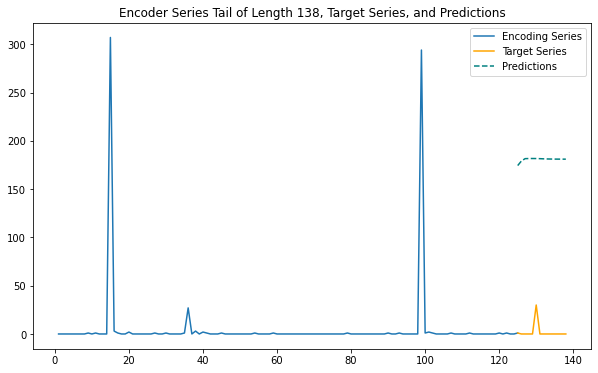

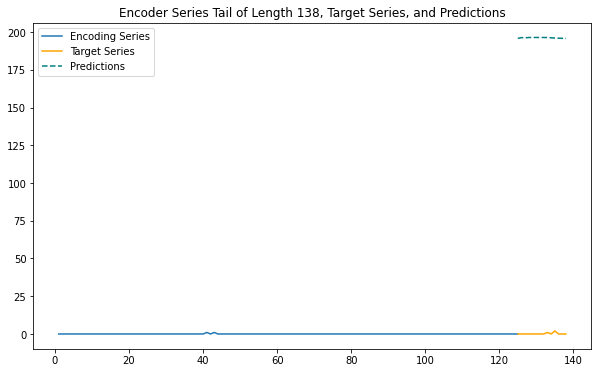

In [40]:
# show plots for a few items
max_show = 2
for i in range(min(items, max_show)):
  pred_1 = predict_and_plot(encoder_input_data, decoder_target_data, cat_features,i)

In [41]:
# ItemID = 38 (37th row) has high peak in validation period <--- that might not be true anymore after changing the dates
# pred_2 = predict_and_plot(encoder_input_data, decoder_target_data, cat_features, 37)

#### Define function for calculating prediction for all item and rescale predictions

In [42]:
def predict_all_items(encoder_input_data, decoder_target_data, cat_features):
    
    num_items = encoder_input_data.shape[0]
    all_predictions = np.zeros(shape=(14,num_items))


    for sample_ind in range(num_items):
      if sample_ind%1000 == 0:
        print("Current Status: ", sample_ind, " items")

      # sample_ind:sample_ind+1,:,: : encoder series of the item we want to predict
      # encode_series: final state vector after feeding in encoder series
      encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
      
      # predict for 14 days
      # Do not use first features (daily_sales), cuz thats what we wanna predict
      # decoder_target_data shape: (num_items, num_days, num_features_sim) (1,14,1)
      decoderArray = decoder_target_data[sample_ind:sample_ind+1,:,1:]
      # Select cat features (just pick one day (day 0), as the same for every day anyway)
      cat_features_item = cat_features[sample_ind:sample_ind+1,:,:]
      pred_series = decode_sequence(encode_series,num_features,decoderArray, cat_features_item)

      # rescale the predicted series
      rescaled_pred_series = rescale(pred_series.reshape(14,1))

      # add rescaled predicted series for all item to array which contains all
      all_predictions[:,sample_ind] = rescaled_pred_series

    return all_predictions

# Create submission data

#### Preprocessing encoder, decoder and target data for testing

In [43]:
# shape: item, days, features

# trys to open existing files
try:
  if override_saved:
    print("Saving new data")
    raise IOError
  encoder_input_data = load('./data/seq2seq_intermediate/encoder_input_data_test.npy')
  decoder_target_data = load('./data/seq2seq_intermediate/decoder_target_data_test.npy')
except IOError as e:
  if not override_saved:
    print(f"Data could not be found. Encoder and decoder data will be created again, {e}")
  # sample of series from train_enc_start to train_enc_end  
  encoder_input_data = get_time_block_series(series_array, date_to_index, test_enc_start, test_enc_end)
  encoder_input_data, scaler_pred = transform_series_encode(encoder_input_data,num_features,scaler)

  # sample of series from train_pred_start to train_pred_end 
  decoder_target_data = get_time_block_series(series_array, date_to_index, test_pred_start, test_pred_end)
  decoder_target_data = transform_series_decode(decoder_target_data, scaler_pred ,num_features)
  
  # save preprocessed data
  save('./data/seq2seq_intermediate/encoder_input_data_train.npy', encoder_input_data)
  save('./data/seq2seq_intermediate/decoder_target_data_train.npy', decoder_target_data)
  print("saved succesfully")

Saving new data
saved succesfully


#### Create final submission

In [44]:
#raise Exception("Remove this exception if you really want to sumbit the data.")

validation_predicts = predict_all_items(encoder_input_data, decoder_target_data, cat_features)

#clip negative values to zero
validation_predicts[validation_predicts < 0] = 0

submission_data = validation_predicts.T

dates_all = dynamic_features.columns.to_list()
dates_validation = dates_all[-14:]

submission_data = pd.DataFrame(data=submission_data,index=range(1,items+1),columns=dates_validation)

submission_data.index.name = 'itemID'
submission_data.to_csv('model_submissions/submission_seq2seq_daily_new_2.csv',sep='|')

print(submission_data.shape)

Current Status:  0  items
Current Status:  1000  items
Current Status:  2000  items
Current Status:  3000  items
Current Status:  4000  items
Current Status:  5000  items
Current Status:  6000  items
Current Status:  7000  items
Current Status:  8000  items
Current Status:  9000  items
Current Status:  10000  items
(10463, 14)


# Save Model for later prediction


In [45]:
# TODO Save the model
 